In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path
from pathlib import Path
import imageio
import os
import json
import pandas as pd
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow
from PIL import Image
train_scc_dir="/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Training/train/scc"
train_mel_dir="/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Training/train/mel"
train_bcc_dir="/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Training/train/bcc"
val_scc_dir="/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Validation/scc" #location on drive
val_mel_dir="/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Validation/mel"
val_bcc_dir="/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Validation/bcc"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mahotas
!pip install ace_tools  # Install the missing module
!pip install ace_tools_open
import mahotas

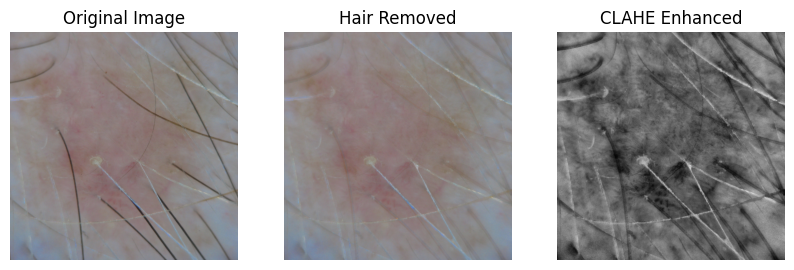

Processed image: bcc01230.jpg | Category: BCC


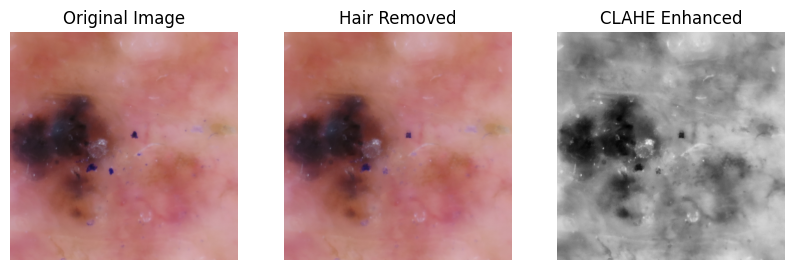

Processed image: bcc01418.jpg | Category: BCC


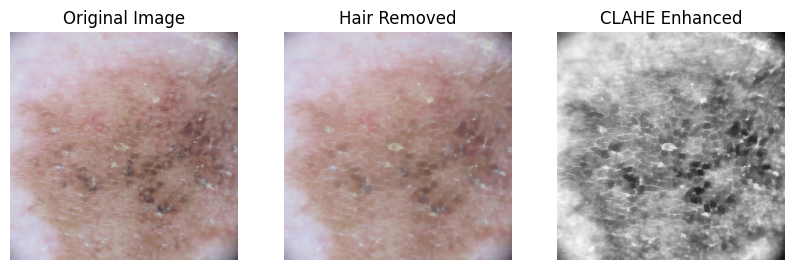

Processed image: mel02691.jpg | Category: Melanoma


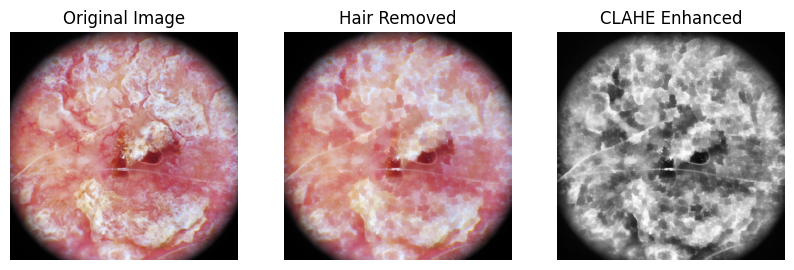

Processed image: scc00011.jpg | Category: SCC


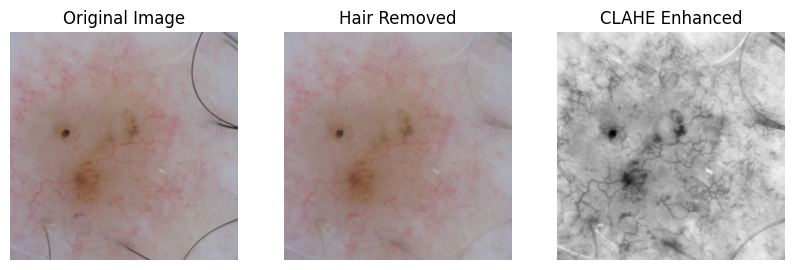

Processed image: bcc00562.jpg | Category: BCC


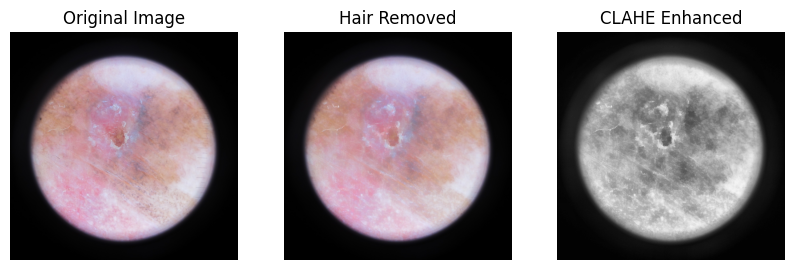

Processed image: mel01671.jpg | Category: Melanoma


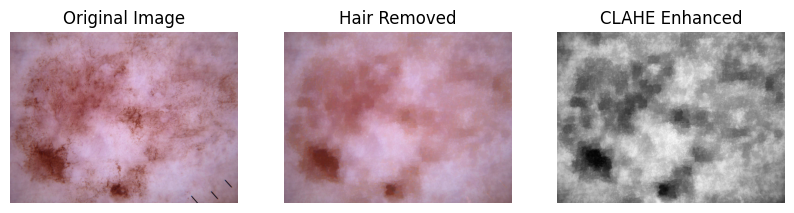

Processed image: mel00426.jpg | Category: Melanoma


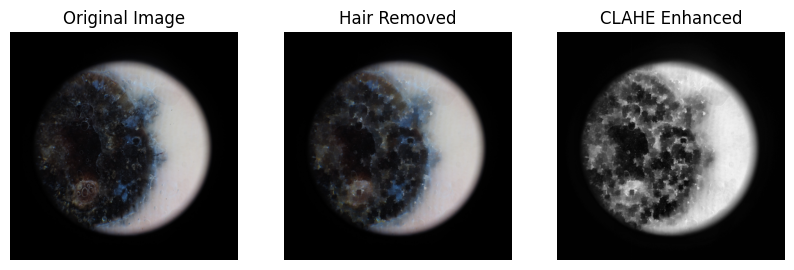

Processed image: mel01265.jpg | Category: Melanoma


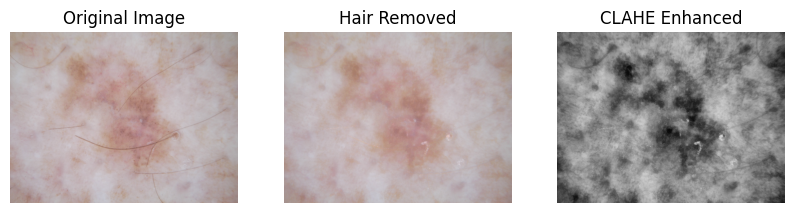

Processed image: mel01545.jpg | Category: Melanoma


In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Hair removal function (simplified)
def remove_hair(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(grayscale_image, cv2.MORPH_BLACKHAT, kernel)
    _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    hair_removed_image = cv2.inpaint(image, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    return hair_removed_image

# Basic preprocessing with contrast enhancement using CLAHE
def preprocess_image(image_path, show=False):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Could not load image from path {image_path}")

    # Step 1: Hair removal
    hair_removed_image = remove_hair(image)

    # Step 2: Convert to grayscale and apply CLAHE directly
    gray_image = cv2.cvtColor(hair_removed_image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)

    if show:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(hair_removed_image, cv2.COLOR_BGR2RGB))
        plt.title('Hair Removed')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(clahe_image, cmap='gray')
        plt.title('CLAHE Enhanced')
        plt.axis('off')
        plt.show()

    return image, hair_removed_image, clahe_image

scc_images = [os.path.join(train_scc_dir, f) for f in os.listdir(train_scc_dir) if f.endswith('.jpg')]
mel_images = [os.path.join(train_mel_dir, f) for f in os.listdir(train_mel_dir) if f.endswith('.jpg')]
bcc_images = [os.path.join(train_bcc_dir, f) for f in os.listdir(train_bcc_dir) if f.endswith('.jpg')]

# Label and combine images
scc_labeled = [(img, 'SCC') for img in scc_images]
mel_labeled = [(img, 'Melanoma') for img in mel_images]
bcc_labeled = [(img, 'BCC') for img in bcc_images]
all_images = scc_labeled + mel_labeled + bcc_labeled
random.shuffle(all_images)

# Select images to process (first 9 for visualization)
selected_images = all_images[:9]

# Process and display selected images
for image_path, label in selected_images:
    show = True
    original_image, hair_removed_image, enhanced_image = preprocess_image(image_path, show=show)
    print(f"Processed image: {image_path.split('/')[-1]} | Category: {label}")


In [ ]:
!pip install scipy
!pip install scikit-image  # Install scikit-image if you haven't already


In [ ]:
import numpy as np
from scipy.stats import skew, entropy, kurtosis
import cv2
# Import necessary functions from skimage.feature
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.color import rgb2gray #Import rgb2gray from skimage.color

# Color features extraction
def extract_color_features(image):
    color_spaces = {
        'BGR': image,
        'HSV': cv2.cvtColor(image, cv2.COLOR_BGR2HSV),
        'LAB': cv2.cvtColor(image, cv2.COLOR_BGR2LAB),
        'Gray': cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    }

    feature_vector = []
    for space, img in color_spaces.items():
        if space == 'Gray':
            hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
            feature_vector.extend(calculate_hist_stats(hist))
        else:
            for channel in range(img.shape[2]):
                hist = cv2.calcHist([img], [channel], None, [256], [0, 256]).flatten()
                feature_vector.extend(calculate_hist_stats(hist))
    return np.array(feature_vector)

def calculate_hist_stats(hist):
    return [
        np.mean(hist), np.argmax(hist), np.std(hist), skew(hist), np.sum(hist**2), entropy(hist), kurtosis(hist)
    ]

# Texture features extraction
def extract_texture_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    glcm_features = [graycoprops(glcm, prop).ravel() for prop in ('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation')]
    glcm_features = np.concatenate(glcm_features)

    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 1), density=True)

    return np.concatenate((glcm_features, lbp_hist))

# Shape features extraction using HOG
def extract_hog_features(image):
    gray_image = rgb2gray(image)
    hog_features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
    return hog_features

# Main feature extraction pipeline
def extract_features(image_path):
    image = cv2.imread(image_path)
    preprocessed_image = preprocess_image(image_path)

    color_features = extract_color_features(image)  # Use original image for color features
    texture_features = extract_texture_features(image)
    shape_features = extract_hog_features(image)

    return np.concatenate((color_features, texture_features, shape_features))

# --- DataFrame Generation Part ---

# Generate DataFrame with extracted features
def generate_features_dataframe(image_paths, labels):
    feature_list = []
    for image_path, label in zip(image_paths, labels):
        features = extract_features(image_path)
        feature_list.append(np.append(features, label))

    feature_names = [f"feat_{i}" for i in range(len(feature_list[0]) - 1)] + ["label"]
    df = pd.DataFrame(feature_list, columns=feature_names)
    return df


# Load images with labels
scc_images = [os.path.join(train_scc_dir, f) for f in os.listdir(train_scc_dir) if f.endswith('.jpg')]
mel_images = [os.path.join(train_mel_dir, f) for f in os.listdir(train_mel_dir) if f.endswith('.jpg')]
bcc_images = [os.path.join(train_bcc_dir, f) for f in os.listdir(train_bcc_dir) if f.endswith('.jpg')]

# Label and combine images
scc_labeled = [(img, 'SCC') for img in scc_images]
mel_labeled = [(img, 'Melanoma') for img in mel_images]
bcc_labeled = [(img, 'BCC') for img in bcc_images]
all_images = scc_labeled + mel_labeled + bcc_labeled
random.shuffle(all_images)

# Generate DataFrame for all images
image_paths = [img[0] for img in all_images]
labels = [img[1] for img in all_images]
df = generate_features_dataframe(image_paths, labels)
print(df.head())

